# ValidateDONutrients

Ben Roberts, 2022

Perform a validtion of FVCOM-ICM water quality parameter output against observations compiled in a [database](https://github.com/bedaro/puget_sound_obsdata). This is loosely based on a Python notebook I wrote in summer 2020 for validation of King County's Puget Sound Aquatic Biogeochemical Cycling (PSABC) model, and most of the plots are designed to mimic the ones Ecology uses in their Bounding Scenarios report.

## Parameters

 * `model_output_pattern`: A glob pattern of all the NetCDF files from the hydrodynamic model run.
 * `run_name`: The name of this particular run, used to name the output files.
 * `start_date`: A plain text start date for when the model run began, which will be read with pd.Timestamp.
 * `end_date`: A plain text end date for when to stop validating the model output. This can just be set to None to use the end of the model output, but some ways to run the model let it continue running after boundary condition files have ended, and after that point this will corrupt the fit statistics.
 * `exclude_station_ids`: A sequence of station IDs to exclude from the validation, even though they fall within the model domain and had observations during the run period.
 * `stats_max_per_station`: To deal with automated buoys that have observations at a much higher frequency than human-collected data, any station with a total number of observations that exceeds this threshold will be subsampled randomly.

In [1]:
model_output_pattern = '/net/babaracus/home/benr/wqmodels/ssm/ictests/2014_wqm_3temp13/outputs/ssm_FVCOMICM_*.nc'
run_name = 'ictest_2014_wqm_3temp13'
start_date = '2014-01-01'
end_date = '2014-12-31'
#end_date = None

# Don't validate with data from the Pacific coast (Willapa Bay, Grays Harbor)
exclude_station_ids = ('WPA001','WPA003','WPA004','WPA006','WPA007',
                       'WPA008','WPA102','WPA113','GYS004','GYS008',
                       'GYS009','GYS015','GYS016')
stats_max_per_station = 240

import os.path as path
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import MFDataset
import matplotlib.pyplot as plt
import db
import validation_util as vu

In [2]:
out_file = lambda name: path.join("notebook_outs", run_name + "_" + name)

In [3]:
model_output = MFDataset(model_output_pattern)
model_output

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: 
    institution: DOE/PNNL/MSL/BSRC
    source: FVCOM-ICM 3.0
    history: model started at: 23/05/2022   09:30
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'nine', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'siglay', 'siglev', 'h', 'nv', 'time', 'iint', 'zeta', 'salinity', 'temp', 'depth', 'CCHL1', 'DOXG', 'LDOC', 'RDOC', 'LPOC', 'RPOC', 'B1', 'B2', 'NH4', 'NO3', 'LDON', 'RDON', 'LPON', 'RPON', 'PO4', 'TDIC', 'TALK', 'pH', 'pCO2', 'IAVG')
    groups = ()

In [4]:
engine = db.connect()
v = vu.ModelValidator(start_date, model_output, engine=engine, end_date=end_date)
display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2014-01-01 08:00:00+00:00 to 2014-12-31 08:00:00+00:00'

In [5]:
o2_obs = v.get_obsdata('o2', exclude_stations=exclude_station_ids)
print(f'{len(o2_obs)} total DO measurements')
print(f'{len(o2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
o2_obs.head()

605586 total DO measurements
7870 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
18807459,2014-01-01 08:00:00+00:00,1.204,6.86,PointWilliams,None,o2
19532131,2014-01-01 08:00:00+00:00,5.036,6.84,Dockton,None,o2
18807460,2014-01-01 08:15:00+00:00,1.214,6.83,PointWilliams,None,o2
19532132,2014-01-01 08:15:00+00:00,5.285,6.74,Dockton,None,o2
18807461,2014-01-01 08:30:00+00:00,1.218,6.83,PointWilliams,None,o2


In [6]:
nh4_obs = v.get_obsdata('nh4', exclude_stations=exclude_station_ids)
# Fix units to match the model output
nh4_obs['value'] *= 14.01/1000
print(f'{len(nh4_obs)} total NH4 measurements')
print(f'{len(nh4_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
nh4_obs.head()

1556 total NH4 measurements
0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
18284740,2014-01-21 16:45:00+00:00,24.7,0.0068,CK200P,None,nh4
18284744,2014-01-21 16:45:00+00:00,34.6,0.0026,CK200P,None,nh4
18284748,2014-01-21 16:46:00+00:00,14.7,0.0025,CK200P,None,nh4
18289451,2014-01-21 18:16:00+00:00,1.0,0.0026,JSUR01,None,nh4
18301869,2014-01-21 18:58:00+00:00,54.5,0.0761,KSSK02,None,nh4


In [7]:
no23_obs = v.get_obsdata('no23', exclude_stations=exclude_station_ids)
print(f'{len(no23_obs)} total NO2+NO3 measurements')
print(f'{len(no23_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
no23_obs.head()

1146 total NO2+NO3 measurements
0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
18284737,2014-01-21 16:43:00+00:00,54.50,31.977159,CK200P,None,no23
18284741,2014-01-21 16:45:00+00:00,24.70,33.119201,CK200P,None,no23
18284745,2014-01-21 16:45:00+00:00,34.60,32.476802,CK200P,None,no23
18284749,2014-01-21 16:46:00+00:00,14.70,32.619557,CK200P,None,no23
18284752,2014-01-21 16:47:00+00:00,0.96,33.119201,CK200P,None,no23


In [8]:
no3_obs = v.get_obsdata('no3', exclude_stations=exclude_station_ids)
print(f'{len(no3_obs)} total NO3 measurements')
print(f'{len(no3_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
no3_obs.head()

724 total NO3 measurements
0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
18267177,2014-06-05 14:55:37.999987+00:00,2.728,16.355,P20,None,no3
18267176,2014-06-05 14:55:37.999987+00:00,5.288,16.340,P20,None,no3
18267175,2014-06-05 14:55:37.999987+00:00,10.463,16.296,P20,None,no3
18267174,2014-06-05 14:55:37.999987+00:00,20.506,16.668,P20,None,no3
18267173,2014-06-05 14:55:37.999987+00:00,30.712,17.604,P20,None,no3


In [9]:
no2_obs = v.get_obsdata('no2', exclude_stations=exclude_station_ids)
print(f'{len(no2_obs)} total NO2 measurements')
print(f'{len(no2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
no2_obs.head()

724 total NO2 measurements
0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
id,,,,,,
18268431,2014-06-05 14:55:37.999987+00:00,2.728,0.445,P20,None,no2
18268430,2014-06-05 14:55:37.999987+00:00,5.288,0.460,P20,None,no2
18268429,2014-06-05 14:55:37.999987+00:00,10.463,0.504,P20,None,no2
18268428,2014-06-05 14:55:37.999987+00:00,20.506,0.432,P20,None,no2
18268427,2014-06-05 14:55:37.999987+00:00,30.712,0.396,P20,None,no2


Combine NO3 and NO2 measurements, then add them to the no23_obs DataFrame

NB: This assumes there is a matching NO3 measurement for every NO2 measurement. That's dangerous, as if any NO3 measurements are missing, I'm not sure how the addition of the Series is handled. It should result in a NaN that needs to be dropped.

In [10]:
common_idx = ['datetime','location_id','depth']
combined_no23 = pd.DataFrame(no3_obs.set_index(common_idx)['value'] + no2_obs.set_index(common_idx)['value']).reset_index()
combined_no23['parameter_id'] = 'no23'
combined_no23.head()

,datetime,location_id,depth,value,parameter_id
0,2014-06-05 14:55:37.999987+00:00,P20,2.728,16.8,no23
1,2014-06-05 14:55:37.999987+00:00,P20,5.288,16.8,no23
2,2014-06-05 14:55:37.999987+00:00,P20,10.463,16.8,no23
3,2014-06-05 14:55:37.999987+00:00,P20,20.506,17.1,no23
4,2014-06-05 14:55:37.999987+00:00,P20,30.712,18.0,no23


In [11]:
no23_obs = pd.concat([no23_obs, combined_no23])
# Fix units to match the model output
no23_obs['value'] *= 14.01/1000
print(f'{len(no23_obs)} total NO2+NO3 measurements')
print(f'{len(no23_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
no23_obs.head()

1870 total NO2+NO3 measurements
0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id
18284737,2014-01-21 16:43:00+00:00,54.50,0.448,CK200P,None,no23
18284741,2014-01-21 16:45:00+00:00,24.70,0.464,CK200P,None,no23
18284745,2014-01-21 16:45:00+00:00,34.60,0.455,CK200P,None,no23
18284749,2014-01-21 16:46:00+00:00,14.70,0.457,CK200P,None,no23
18284752,2014-01-21 16:47:00+00:00,0.96,0.464,CK200P,None,no23


In [12]:
all_station_ids = pd.concat([df['location_id'] for df in (o2_obs,nh4_obs,no23_obs)]).drop_duplicates()
stations = gpd.read_postgis("SELECT * FROM obsdata.stations", con=engine)
stations = stations.loc[stations['name'].isin(all_station_ids)]
print(f'{len(stations)} total stations in validation set')
stations.head()

96 total stations in validation set


,name,description,geom
0,RSR837,Strait of Georgia: Rosario Strait - Peapod Rock,POINT (517470.419 5384851.335)
10,HCB007,Hood Canal - Lynch Cove,POINT (505409.261 5249433.731)
11,HCB010,"Hood Canal - Send Creek, Bangor Post 9/11/2001...",POINT (513512.242 5279306.044)
15,SIN001,Sinclair Inlet - Naval Shipyards,POINT (526958.030 5266349.377)
16,SJF000,Strait of Juan de Fuca - South of Cattle Point...,POINT (498150.179 5362613.353)


In [13]:
xs = model_output['x'][:]
ys = model_output['y'][:]
points = [Point(x, y) for x, y in zip(xs, ys)]
model_points = gpd.GeoDataFrame({"geometry": points}, crs='epsg:32610')
station_nodes = gpd.tools.sjoin_nearest(stations, model_points).set_index('name').rename(columns={'index_right': 'node'})
print(f'{len(station_nodes)} stations inside grid')
station_nodes.head()

96 stations inside grid


,description,geom,node
name,,,
RSR837,Strait of Georgia: Rosario Strait - Peapod Rock,POINT (517470.419 5384851.335),5101
HCB007,Hood Canal - Lynch Cove,POINT (505409.261 5249433.731),14048
HCB010,"Hood Canal - Send Creek, Bangor Post 9/11/2001...",POINT (513512.242 5279306.044),9886
SIN001,Sinclair Inlet - Naval Shipyards,POINT (526958.030 5266349.377),11792
SJF000,Strait of Juan de Fuca - South of Cattle Point...,POINT (498150.179 5362613.353),3635


In [14]:
o2_obs = o2_obs.merge(station_nodes, left_on='location_id', right_index=True)
nh4_obs = nh4_obs.merge(station_nodes, left_on='location_id', right_index=True)
no23_obs = no23_obs.merge(station_nodes, left_on='location_id', right_index=True)
o2_obs.head()

,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
18807459,2014-01-01 08:00:00+00:00,1.204,6.86,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10976
18807460,2014-01-01 08:15:00+00:00,1.214,6.83,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10976
18807461,2014-01-01 08:30:00+00:00,1.218,6.83,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10976
18807462,2014-01-01 08:45:00+00:00,1.219,6.84,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10976
18807463,2014-01-01 09:00:00+00:00,1.219,6.83,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10976


In [15]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in o2_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(o2_obs.loc[o2_obs['cast_id'].isna()]))

o2_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
o2_validation_df.to_csv(out_file("o2_validation.csv"), index=False)
o2_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_NB,7326,000b079f-68ab-48e1-9a99-39e000916f83,2014-10-03 00:14:39.000019+00:00,1098,3.754571,2,6.542848,7.108348
1,HC_NB,7326,000b079f-68ab-48e1-9a99-39e000916f83,2014-10-03 00:14:39.000019+00:00,1098,7.869773,3,6.506501,5.934672
2,HC_NB,7326,000b079f-68ab-48e1-9a99-39e000916f83,2014-10-03 00:14:39.000019+00:00,1098,12.941580,4,6.383869,5.909147
3,HC_NB,7326,000b079f-68ab-48e1-9a99-39e000916f83,2014-10-03 00:14:39.000019+00:00,1098,18.810324,5,6.187215,5.641513
4,HC_NB,7326,000b079f-68ab-48e1-9a99-39e000916f83,2014-10-03 00:14:39.000019+00:00,1098,25.378069,6,6.009530,5.566636
...,...,...,...,...,...,...,...,...,...
103130,P123,1617,NaN,2014-10-26 01:04:31.999968+00:00,1190,49.943000,5,6.898520,4.934167
103131,P123,1617,NaN,2014-10-26 01:04:31.999968+00:00,1190,80.201000,6,5.773027,4.318167
103132,P123,1617,NaN,2014-10-26 01:04:31.999968+00:00,1190,120.318000,8,4.512034,3.535306
103133,P123,1617,NaN,2014-10-26 01:04:31.999968+00:00,1190,170.577000,10,3.227618,3.283273


In [16]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in nh4_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(nh4_obs.loc[nh4_obs['cast_id'].isna()]))

nh4_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
nh4_validation_df.to_csv(out_file("nh4_validation.csv"), index=False)
nh4_validation_df

,location,node,datetime,t,depth,sigma,observed,model
0,CK200P,9311,2014-01-21 16:45:00+00:00,80,24.700,5,0.006800,0.013875
1,CK200P,9311,2014-01-21 16:45:00+00:00,80,34.600,6,0.002600,0.013635
2,CK200P,9311,2014-01-21 16:46:00+00:00,80,14.700,3,0.002500,0.013138
3,CK200P,9311,2014-02-03 17:32:00+00:00,133,24.100,5,0.003500,0.013883
4,CK200P,9311,2014-03-19 15:23:00+00:00,308,54.700,7,0.010300,0.018058
...,...,...,...,...,...,...,...,...
1551,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,29.986,4,0.008846,0.020222
1552,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,51.181,6,0.005044,0.019417
1553,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,80.662,8,0.004678,0.018521
1554,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,110.870,9,0.005249,0.018047


In [17]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in no23_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(no23_obs.loc[no23_obs['cast_id'].isna()]))

no23_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
no23_validation_df.to_csv(out_file("no23_validation.csv"), index=False)
no23_validation_df

,location,node,datetime,t,depth,sigma,observed,model
0,CK200P,9311,2014-01-21 16:43:00+00:00,80,54.500,7,0.448000,0.443864
1,CK200P,9311,2014-01-21 16:45:00+00:00,80,24.700,5,0.464000,0.445534
2,CK200P,9311,2014-01-21 16:45:00+00:00,80,34.600,6,0.455000,0.445042
3,CK200P,9311,2014-01-21 16:46:00+00:00,80,14.700,3,0.457000,0.444486
4,CK200P,9311,2014-01-21 16:47:00+00:00,80,0.960,1,0.464000,0.381629
...,...,...,...,...,...,...,...,...
1865,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,29.986,4,0.292196,0.359758
1866,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,51.181,6,0.321501,0.376049
1867,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,80.662,8,0.329132,0.393507
1868,P136,2813,2014-10-26 08:23:02.999971+00:00,1191,110.870,9,0.332348,0.401629


,Metric,R,RMSE,Bias,n
0,Dissolved Oxygen,0.832131,1.305827,-0.068863,7631
1,Ammonia,0.185664,0.019157,0.005122,1556
2,Total Nitrate+Nitrite,0.785466,0.072136,0.027338,1870


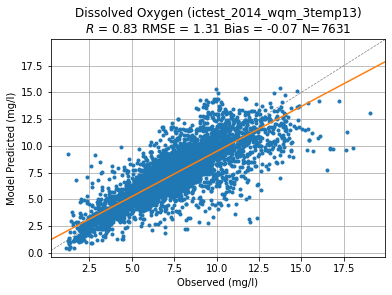

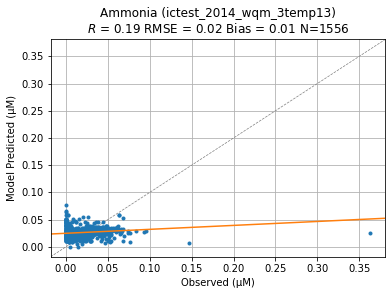

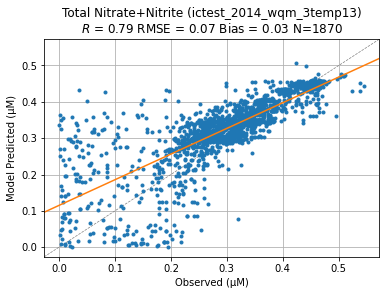

In [18]:
cum_stats = []
for pfx, label, data, unit in zip(("o2","nh4","no23"),
        ("Dissolved Oxygen","Ammonia","Total Nitrate+Nitrite"),
        (o2_validation_df,nh4_validation_df,no23_validation_df),
        ("mg/l","\u03BCM","\u03BCM")):
    if data.empty:
        continue
    # Downsample any stations with a high number of total observations
    # (ie automated buoys), otherwise a small number of stations will skew
    # the results heavily toward just showing how well the model represents
    # a handful of locations
    sampled = []
    for s,group in data.groupby('location'):
        if len(group) > stats_max_per_station:
            samp = group.sample(n=stats_max_per_station)
        else:
            samp = group
        sampled.append(samp)
    sampled_df = pd.concat(sampled)
    fit, rsq, rmse, bias, n = vu.run_stats(sampled_df["observed"], sampled_df["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, sampled_df['observed'], sampled_df['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","Bias","n"]))

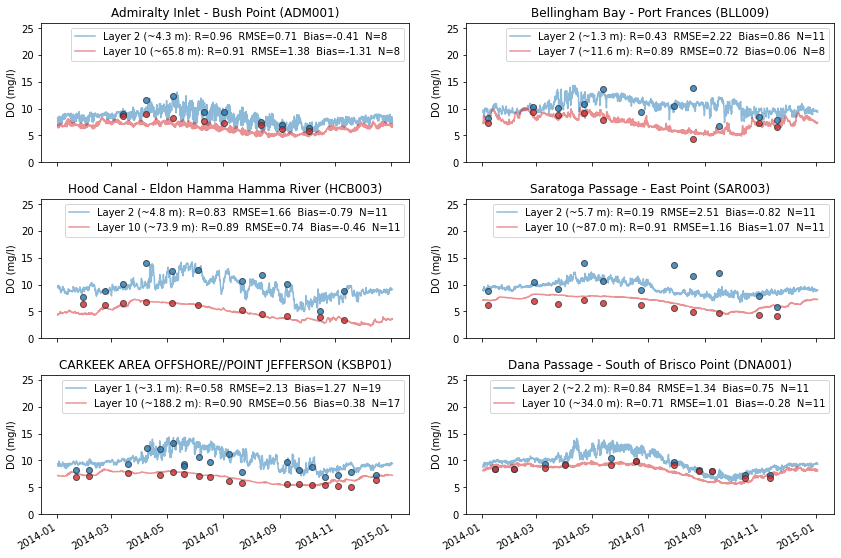

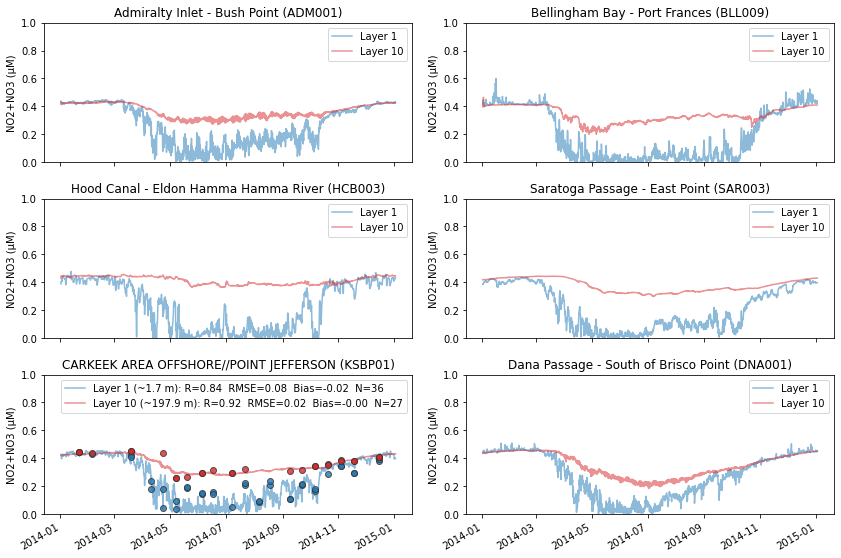

In [19]:
# Build time series plots of DO and nutrients that
# mimic fig 21 in the Bounding Scenarios report

plot_stations = ["ADM001","BLL009","HCB003","SAR003","KSBP01","DNA001"]
colors = ('tab:blue','tab:red')
datasets = {
    "DOXG": {
        "data": o2_validation_df,
        "obsdata": o2_obs,
        "ylabel": "DO (mg/l)",
        "ybound": (0, 26),
        "xbound": (0, 26)
    },
    "NO3": {
        "data": no23_validation_df,
        "obsdata": no23_obs,
        "ylabel": "NO2+NO3 (\u03BCM)",
        "ybound": (0, 1),
        "xbound": (0, 1)
    }
}

for key,vals in datasets.items():
    data = vals['data']
    fig, axs = plt.subplots(3,2, figsize=(12,9))
    for ax,s in zip(np.array(axs).flatten(), plot_stations):
        zs = vu.tsplot_zs(data.loc[data['location'] == s], model_output)
        for z,color in zip(zs, colors):
            selector = (data["location"] == s) & (data["sigma"] == z)
            observed = data.loc[selector]
            if len(observed) == 0:
                # No observations at this station!
                node = station_nodes.loc[s, 'node']
                lbl = f'Layer {z}'
            else:
                havg = observed['depth'].mean()
                lbl = f'Layer {z} (~{havg:.1f} m)'
                node = observed.iloc[0]['node']
                ax.plot(observed["datetime"], observed["observed"], "o",
                        color=color, alpha=0.8, markeredgecolor='.2', zorder=2)

                if len(observed) > 2:
                    fit, r, rmse, bias, n = vu.run_stats(observed["observed"],
                                                         observed["model"])
                    lbl += ": R=%.2f  RMSE=%.2f  Bias=%.2f  N=%d" % (r, rmse, bias, n)

            # Extract the full time series from the output file
            modeled_y = model_output[key][:,z-1,node]
            modeled_x = v.start_date + pd.to_timedelta(model_output['time'][:], 'S')
            ax.plot(modeled_x, modeled_y, color=color, alpha=0.5, label=lbl, zorder=1)
        ax.set(title=f'{station_nodes.loc[s, "description"]} ({s})',
               ylabel=vals['ylabel'], ybound=vals['ybound'])
        ax.legend()
    plt.tight_layout()
    fig.autofmt_xdate()
    fig.savefig(out_file(f'{key}_validation_station_ts.png'))

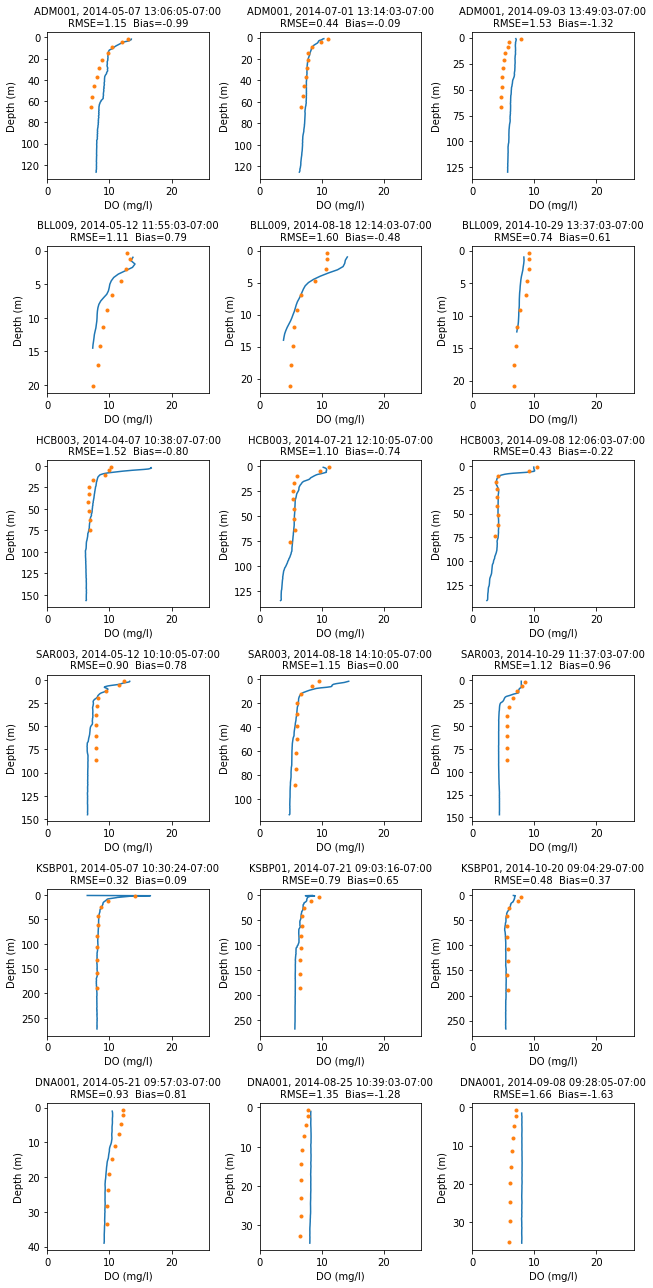

In [20]:
# Ranges of months to generate profile plots for
month_ranges = (
    (4, 5),
    (7, 8),
    (9, 10)
)
rand_seed = 4

for key,vals in datasets.items():
    fig, axs = plt.subplots(len(plot_stations), len(month_ranges),
                            figsize=(3*len(month_ranges), 3 * len(plot_stations)))
    d = vals['data']
    od = vals['obsdata']
    # Keep track of whether or not we found anything to plot among the ranges
    # given from this dataset
    plotted = False
    for i,mr in enumerate(month_ranges):
        for j,s in enumerate(plot_stations):
            ax = axs[j,i]
            # Pick a "random" cast from the time range, using a constant seed for reproducibility
            cast_candidates = od.loc[
                (od['datetime'].dt.month >= mr[0]) & (od['datetime'].dt.month <= mr[-1]) \
                & (od['location_id'] == s) & ~od['cast_id'].isna(), 'cast_id'
            ]
            if len(cast_candidates) == 0:
                continue
            obs_cast_id = cast_candidates.sample(1, random_state=rand_seed).iloc[0]

            obs = od.loc[od['cast_id'] == obs_cast_id].sort_values(by='depth')
            ax.plot(obs['value'], obs['depth'])
            cast_dt = obs['datetime'].iloc[0].tz_convert('US/Pacific')

            # Get model results that correspond to this cast_id. Use vals['data'] to fetch node and t,
            # retrieve all sigma layers, then recalculate matching depths using the same method as
            # process_cast
            node = obs['node'].iloc[0]
            cast_selector = d['cast_id'] == obs_cast_id
            t = d.loc[cast_selector, 't'].iloc[0]
            modeled_x = model_output[key][t,:,node]
            modeled_y = ((model_output['h'][node] + model_output['zeta'][t,node])
                         * model_output['siglay'][:] * -1)
            ax.plot(modeled_x, modeled_y, '.')
            
            fit, r, rmse, bias, n = vu.run_stats(d.loc[cast_selector, "observed"],
                                                 d.loc[cast_selector, "model"])

            ax.set_title(f'{s}, {cast_dt}\nRMSE={rmse:.2f}  Bias={bias:.2f}', fontsize=10)
            ax.set(ylabel='Depth (m)', xlabel=vals['ylabel'], xbound=vals['xbound'])
            ax.set_ylim(ax.get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
            plotted = True

    if plotted:
        fig.tight_layout()
        fig.savefig(out_file(f'{key}_validation_station_pr.png'))
    else:
        plt.close(fig)